In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd

import pandas as pd
from pandas.errors import SettingWithCopyWarning
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr


from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings

import datetime
from datetime import date
import traceback

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
# SettingWithCopyWarning


In [2]:
manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_2020_2023-02-25attempt_at_production.csv", parse_dates= True) #dtype={"fireID": str}
debug = pd.read_csv("/projects/my-public-bucket/fire_spread/DEBUG_WesternUS_2020_2023-02-25attempt_at_production.csv")

In [15]:
manyfr.columns
#manyfr.fireID.unique()

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC',
       'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI',
       'GPM.LATE.v5_ISI', 'fline_diff', 'farea_diff', 'spread_line',
       'spread_lineNight', 'spread_lineDay', 'spread_day'],
      dtype='object')

In [5]:
#plt.scatter(manyfr[manyfr.fireID.astype("str") == "117"].t, manyfr[manyfr.fireID.astype("str") == "117"].farea)


In [5]:
### Correct ignition double counting? 
#manyfr["spread_line_ig"] = manyfr.spread_line    

In [3]:
### Look at % spread on specifc days

time = manyfr.t.unique()

time_sum = []
for i in time: 
    #print(i)
    try:
        at_t = manyfr[manyfr.t == i]
        at_t_spread = at_t[(at_t.spread_line.astype("str") == 'True') | (at_t.spread_line.astype("str") == '1')]
        at_t_ig = at_t[at_t.spread_line.astype("str") == "2"]
        at_t_not_spread = at_t[(at_t.spread_line.astype("str") == 'False') | (at_t.spread_line.astype("str") == '0')]
    except:
        print("Skipping ", i)
        next
    else:
        num_fires = len(at_t.fireID)
        num_spread = len(at_t_spread.fireID)
        num_ig = len(at_t_ig.fireID)
        
        num_percent_spread = num_spread/num_fires
        num_percent_spread_ig = (num_spread + num_ig)/num_fires
        num_percent_ig = num_ig/num_fires
        
        fire_labs_all = str(at_t.fireID)
        fire_labs_spread = str(at_t_spread.fireID)
        fire_labs_ig = str(at_t_ig.fireID)
        
        area = sum(at_t.farea.dropna())
        area_spread = sum(at_t_spread.farea.dropna())
        
        delta_area = sum(at_t.farea_diff.dropna())
        #print(at_t)
        delta_area_spread = sum(at_t_spread.farea_diff.dropna().values)
        #print(delta_area_spread)
        delta_area_ig = sum(at_t_ig.farea.dropna()) ## Repeats from dat to night
        
        area_percent_spread = area_spread/area
        area_percent_spread_ig = (area_spread + delta_area_ig)/area
        area_percent_ig = (delta_area_ig)/area
        
        delta_area_percent_spread = delta_area_spread/area
        delta_area_percent_spread_ig = (delta_area_spread + delta_area_ig)/area
        
        mean_spread_fwi = np.mean(at_t_spread['GPM.LATE.v5_FWI'].dropna())
        mean_not_spread_fwi = np.mean(at_t_not_spread['GPM.LATE.v5_FWI'].dropna())
        max_spread_fwi = np.max(at_t_spread['GPM.LATE.v5_FWI'].dropna())
        
        mean_spread_ffmc = np.mean(at_t_spread['GPM.LATE.v5_FFMC'].dropna())
        mean_not_spread_ffmc = np.mean(at_t_not_spread['GPM.LATE.v5_FFMC'].dropna())
        max_spread_ffmc = np.max(at_t_spread['GPM.LATE.v5_FFMC'].dropna())
        
        time_sum.append([i, num_fires,num_spread, num_ig, 
                         num_percent_spread,num_percent_spread_ig,num_percent_ig, 
                         fire_labs_all, fire_labs_spread, fire_labs_ig, 
                         area, area_spread,
                         delta_area, delta_area_spread, delta_area_ig,
                         area_percent_spread, area_percent_spread_ig, area_percent_ig, 
                         delta_area_percent_spread, delta_area_percent_spread_ig, 
                         mean_spread_fwi, mean_not_spread_fwi, max_spread_fwi,
                         mean_spread_ffmc, mean_not_spread_ffmc, max_spread_ffmc])
        

In [4]:
timeline = pd.DataFrame(data = time_sum, columns = ["t",'num_fires','num_spread', 'num_ig', 
                                                    'num_percent_spread', 'num_percent_spread_ig', 'num_percent_ig', 
                                                    'fire_labs_all', 'fire_labs_spread', 'fire_labs_ig', 
                                                    'area', 'area_spread', 
                                                    'delta_area', 'delta_area_spread', 'delta_area_ig',
                                                    'area_percent_spread', 'area_percent_spread_ig', 'area_percent_ig',
                                                    'delta_area_percent_spread', 'delta_area_percent_spread_ig',
                                                    "mean_spread_fwi", "mean_not_spread_fwi", "max_spread_fwi", 
                                                    "mean_spread_ffmc", "mean_not_spread_ffmc", "max_spread_ffmc"])

In [60]:
#timeline[["t", "farea", "farea_diff", "delta_area_spread"]]
#sum(manyfr[["farea_diff"]].dropna().values)
#at_t
#at_t[(at_t.spread_line.astype("str") == 'True') | (at_t.spread_line.astype("str") == '1')]

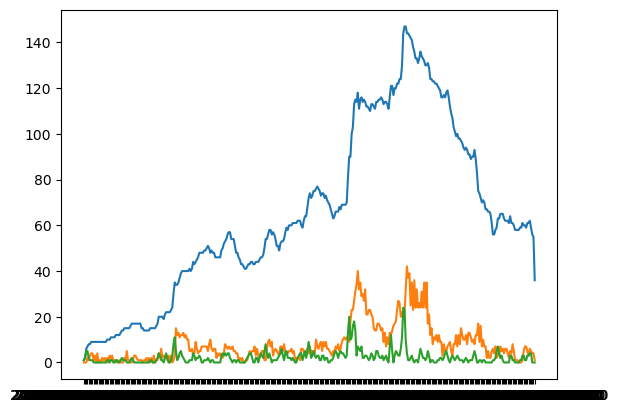

In [5]:
timeline = timeline.sort_values(by = "t")


plt.plot(timeline.t, timeline.num_fires) # blue
plt.plot(timeline.t, timeline.num_spread) # Oragne
plt.plot(timeline.t, timeline.num_ig) # green
#plt.plot(timeline.t, timeline.num_ig + timeline.num_spread )
#timeline.num_spread

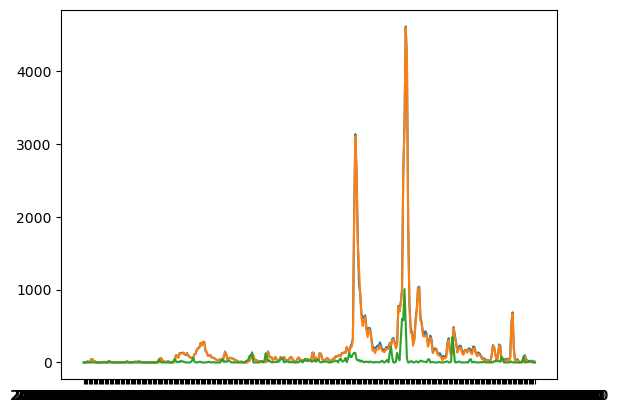

In [62]:


plt.plot(timeline.t, timeline.delta_area.astype("float")) # blue
plt.plot(timeline.t, timeline.delta_area_spread.astype("float")) # Oragne
plt.plot(timeline.t, timeline.delta_area_ig) # green
#plt.plot(timeline.t, timeline.num_ig + timeline.num_spread )
#timeline.num_spread

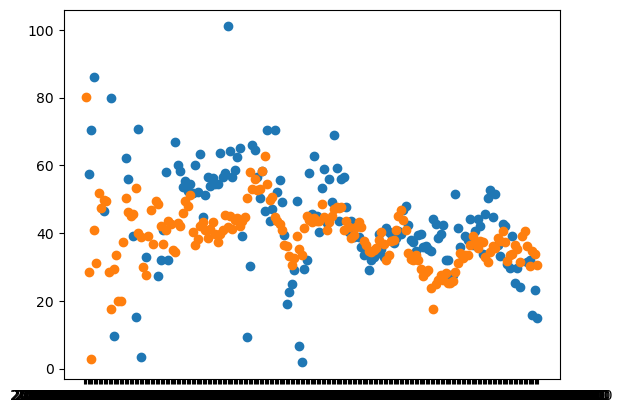

In [63]:
plt.scatter(timeline.t, timeline.mean_spread_fwi) # Blue
plt.scatter(timeline.t, timeline.mean_not_spread_fwi) # oragne

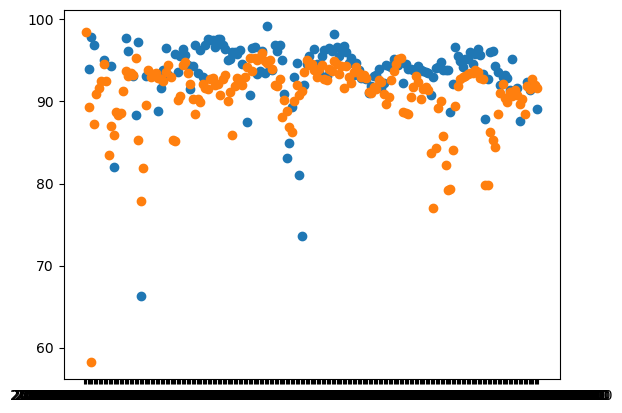

In [64]:
plt.scatter(timeline.t, timeline.mean_spread_ffmc) # Blue
plt.scatter(timeline.t, timeline.mean_not_spread_ffmc) # oragne

pandas.core.series.Series

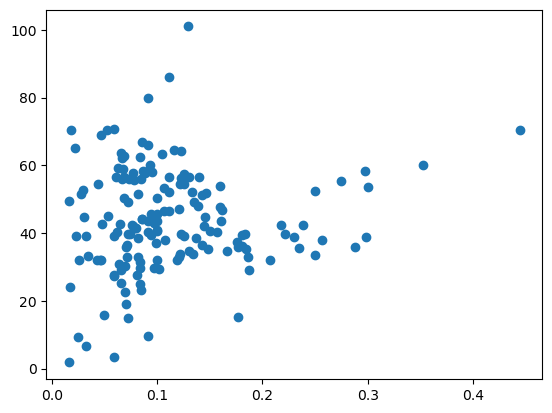

In [65]:
plt.scatter(timeline.num_percent_spread, timeline.mean_spread_fwi)

type(manyfr.t.astype("datetime64[ns]"))

# manyfr_d[manyfr_d.spread_line.astype("str") == "True"].spread_line.unique()
# manyfr_d.spread_line.unique()

pandas.core.series.Series

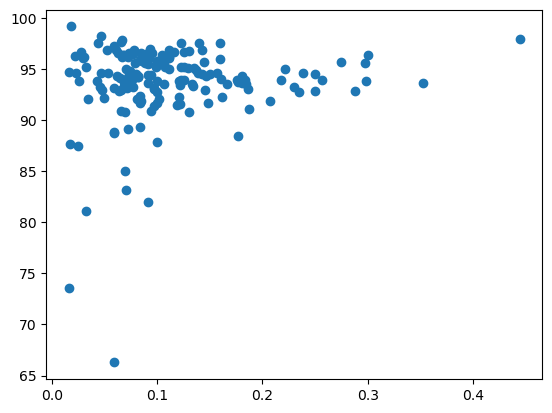

In [66]:
plt.scatter(timeline.num_percent_spread, timeline.mean_spread_ffmc)

type(manyfr.t.astype("datetime64[ns]"))

# manyfr_d[manyfr_d.spread_line.astype("str") == "True"].spread_line.unique()
# manyfr_d.spread_line.unique()

In [6]:


manyfr_d = manyfr[manyfr.t.astype("datetime64[ns]").dt.hour > 0] #daytime only, so the farea_diff can't be larger than 100

final_a = []
for i in manyfr.fireID.unique(): 
    #print(i)
    try:
        final_area = max(manyfr_d.farea[manyfr_d.fireID == i])
    except:
        next
    else:
        spread_area = sum(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "True")].farea_diff) ## Includes both spread days and ignitions bc 2 is interprested as true
        ignition_area = max(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "2")].farea)
        percent_spread = spread_area / final_area
        percent_ignition = ignition_area / final_area
        final_a.append([i, final_area, spread_area, ignition_area, percent_spread, percent_ignition])
        #final_a.append([i, final_area, spread_area, percent_spread, ])
        
        

In [7]:

tmp = []
tmp = pd.DataFrame(data = final_a, columns = ["Id", "Final_area", "spread_area", "ignition_area", "percent_spread", "percent_ignition"])

In [8]:
print(len(tmp))
tmp = tmp[tmp.percent_spread <= 1]
print(len(tmp[tmp.percent_spread <= 1]))


print( sum(tmp.spread_area)/sum(tmp.Final_area)) ## Comes out to larger than 100???? Need to manually exclude numerical weirdnesses
print("Ignition percent: ",  sum(tmp.ignition_area)/sum(tmp.Final_area))


407
397
0.8445587636074318
Ignition percent:  0.12083114522843881


In [9]:
#tmp[tmp.percent_spread >= 1]

29/(426)

0.06807511737089202

0.6167888215485267


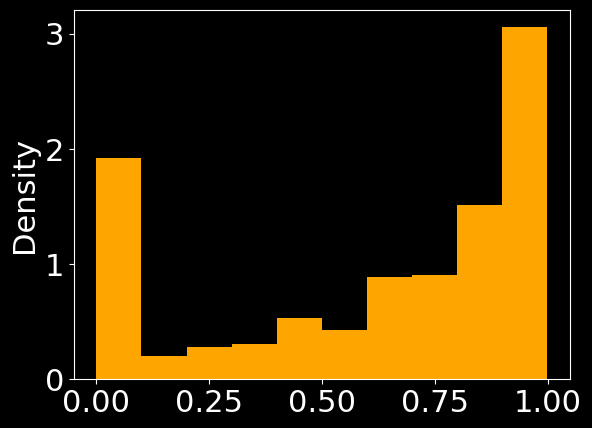

In [11]:
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})
plt.hist(tmp.percent_spread, density= True, color = "orange")
plt.ylabel("Density")
plt.xlabel("")

print(np.mean(tmp.percent_spread))

#plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/dark_precent_spread_histogram_fire_area.png", dpi=800)

0.33490088389797973

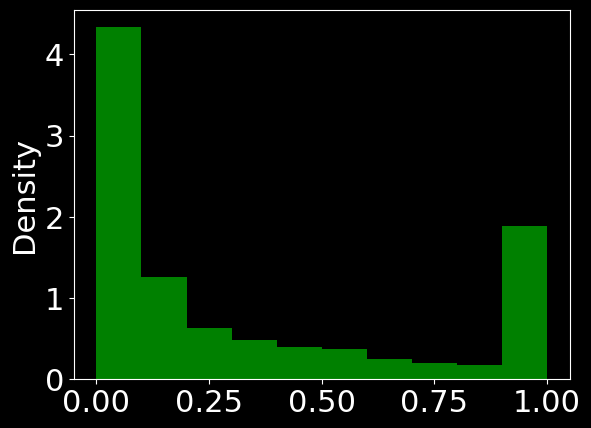

In [16]:
plt.hist(tmp.percent_ignition, density= True, color = "green")
plt.ylabel("Density")
plt.xlabel("")
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

np.mean(tmp.percent_ignition)
#plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/dark_precent_ignition_histogram_fire_area.png", dpi=800)

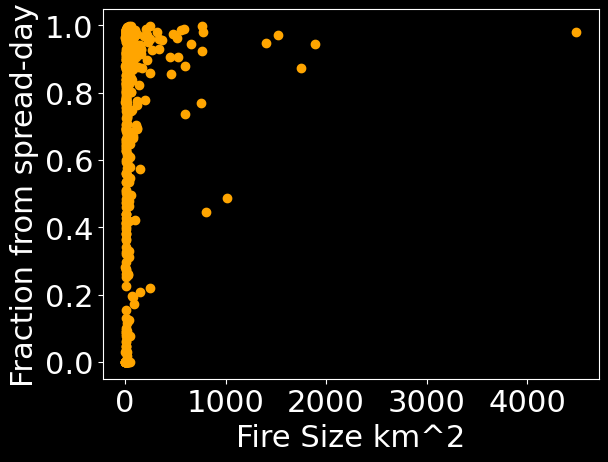

In [14]:
plt.scatter(tmp.Final_area, tmp.percent_spread, color = "orange")
plt.ylabel("Fraction from spread-day")
plt.xlabel("Fire Size km^2")
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/dark_spread_percent_fire_size.png", dpi=800)

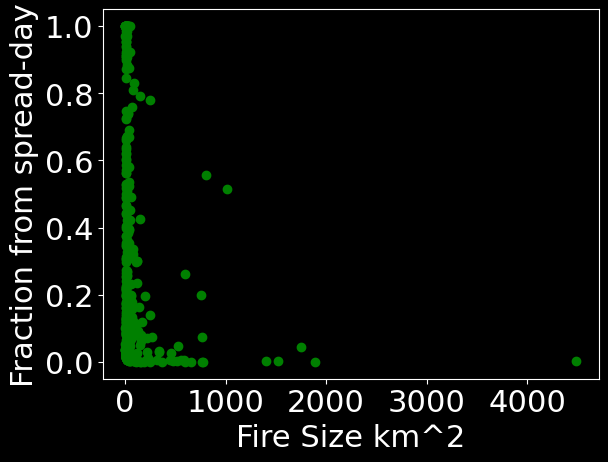

In [15]:
plt.scatter(tmp.Final_area, tmp.percent_ignition, color = "green")
plt.ylabel("Fraction from spread-day")
plt.xlabel("Fire Size km^2")
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/dark_ig_percent_fire_size.png", dpi=800)

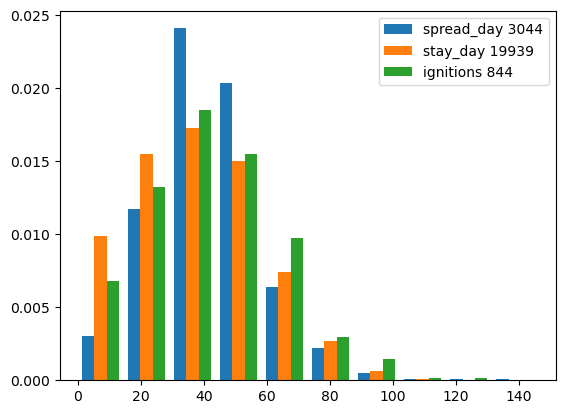

In [17]:
#plt.hist(manyfr["GPM.LATE.v5_FWI"], c = manyfr.spread_line )

#bins = np.linspace(0, max(manyfr["GPM.LATE.v5_FWI"].dropna()), 40)
#bins

spread_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "True"]))
n_spread_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "False"]))
ig_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "2"]))

plt.hist([manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "True"], manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "False"], manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line.astype("str") == "2"]], label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
plt.legend(loc='upper right')
plt.show()

In [18]:
spread_n

'3044'

In [19]:
### Create shifted weather data. 
manyfr = manyfr.sort_values(by = ["t"])
manyfr["fwilag_24"] = manyfr["GPM.LATE.v5_FWI"].shift(2)

manyfr

,Unnamed: 0,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,...,GPM.LATE.v5_FFMC,GPM.LATE.v5_FWI,GPM.LATE.v5_ISI,fline_diff,farea_diff,spread_line,spread_lineNight,spread_lineDay,spread_day,fwilag_24
3437,3437,1,1,0.141000,1.177624,0.000000,0.0,7.092199,0.760000,2020-05-01 00:00:00,...,98.42844,78.757650,34.802544,NaN,NaN,2,2,NaN,2,NaN
3438,3438,1,0,0.141000,1.177624,0.000000,0.0,7.092199,0.000000,2020-05-01 12:00:00,...,NaN,NaN,NaN,NaN,NaN,2,NaN,2,False,NaN
14090,14090,2,2,0.282000,2.355248,0.000000,0.0,7.092199,3.430000,2020-05-01 12:00:00,...,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,78.75765
12506,12506,3,3,0.370971,2.469572,2.469572,0.0,8.086887,0.963333,2020-05-02 00:00:00,...,85.85292,19.769463,9.506055,NaN,NaN,2,2,NaN,2,NaN
3439,3439,2,1,0.282000,2.355248,0.000000,0.0,7.092199,0.235000,2020-05-02 00:00:00,...,98.48058,80.275650,33.825962,0.000000,1.410000e-01,False,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5193,26,0,53.691435,39.911171,0.000000,26.0,0.484249,0.000000,2020-10-31 12:00:00,...,NaN,NaN,NaN,0.000000,0.000000e+00,False,NaN,False,False,NaN
9243,9243,4895,0,454.783750,128.890787,0.000000,63.5,10.763357,0.000000,2020-10-31 12:00:00,...,NaN,NaN,NaN,0.000000,0.000000e+00,False,NaN,False,False,NaN
9248,9248,18,0,6.330721,13.133841,0.000000,0.0,2.843278,0.000000,2020-10-31 12:00:00,...,NaN,NaN,NaN,0.000000,0.000000e+00,False,NaN,False,False,NaN
7906,7906,13716,0,657.070044,138.884295,0.000000,96.0,20.874487,0.000000,2020-10-31 12:00:00,...,NaN,NaN,NaN,-1.542072,1.591616e-12,False,NaN,False,False,NaN


/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


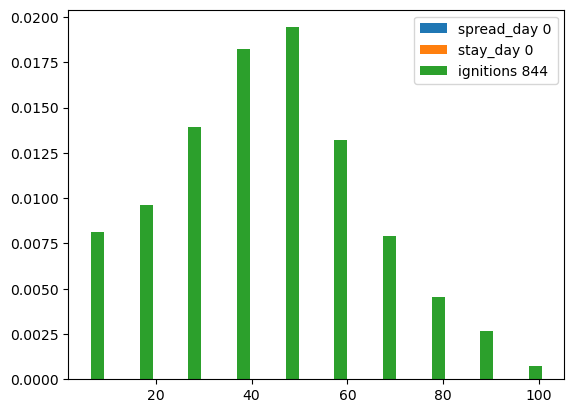

In [20]:
#bins = np.linspace(0, max(manyfr["GPM.LATE.v5_FFMC"].dropna()), 40)

spread_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "1"]))
n_spread_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "0"]))
ig_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "2"]))

plt.hist([manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "1"], manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "0"], manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "2"]],label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
plt.legend(loc='upper right')
plt.show()

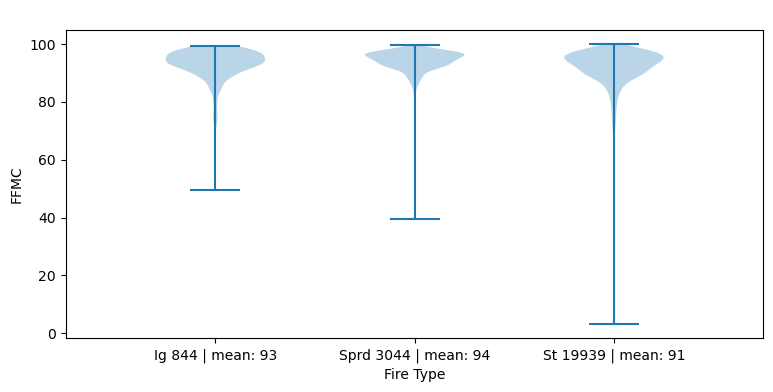

In [21]:
spread_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "True"]))
n_spread_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "False"]))
ig_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "2"]))


sprd_days = manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "True"].dropna().to_numpy()
st_days = manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "False"].dropna().to_numpy()
ig_days = manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "2"].dropna().to_numpy()
               
# violin_df = pd.DataFrame(data = [sprd_days, st_days, ig_days], 
#                 columns = ["Spread-days", "Stay-days", "Ignitions"])

# plt.violinplot( dataset = [sprd_days, st_days, ig_days]
#                 ) #label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n], density = True
#plt.legend(loc='upper right')
# plt.show()
#violin_df
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "True"].values
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "0"]
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "2"] 
#sprd_days         

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Fire Type')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

ax1.set_title(' ')
ax1.set_ylabel('FFMC')
ax1.violinplot([ig_days, sprd_days, st_days ])

#labels = ["Ignitions" + " " + ig_n, 'Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]
labels = ["Ig" + " " + ig_n + " | mean: " + str(round(np.mean(ig_days))), 'Sprd' + " " + spread_n + " | mean: " + str(round(np.mean(sprd_days))), 'St' + " " + n_spread_n + " | mean: " + str(round(np.mean(st_days)))]


set_axis_style(ax1, labels)

# for i, pc in enumerate(fig["bodies"], 1):
#     if i == 0:
#         pc.set_facecolor('green')
#     if i == 1:
#         pc.set_facecolor('#fe953e')
#     if i == 2:
#         pc.set_facecolor('#2f7fb9')
#     pc.set_edgecolor('black')

   # 'stay-day': '#2f7fb9','spread-day':'#fe953e'
plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/FFMC_distribution.png", dpi=800)
    

In [22]:
manyfr.columns

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC',
       'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI',
       'GPM.LATE.v5_ISI', 'fline_diff', 'farea_diff', 'spread_line',
       'spread_lineNight', 'spread_lineDay', 'spread_day', 'fwilag_24'],
      dtype='object')

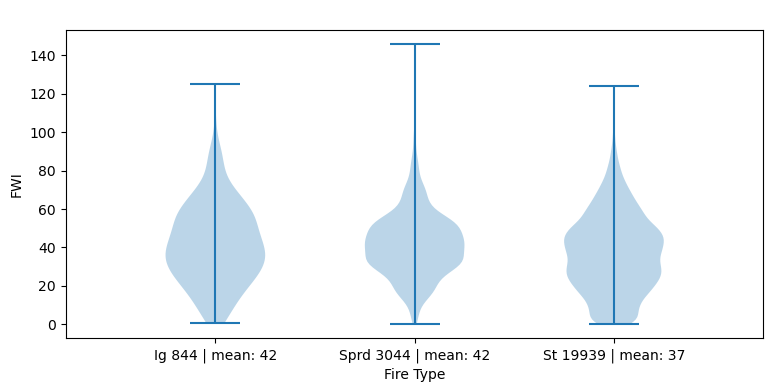

In [23]:
pread_n = str(len(manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "True"]))
n_spread_n = str(len(manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "False"]))
ig_n = str(len(manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "2"]))


sprd_days = manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "True"].dropna().to_numpy()
st_days = manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "False"].dropna().to_numpy()
ig_days = manyfr['GPM.LATE.v5_FWI'][manyfr.spread_line.astype("str") == "2"].dropna().to_numpy()
               
# violin_df = pd.DataFrame(data = [sprd_days, st_days, ig_days], 
#                 columns = ["Spread-days", "Stay-days", "Ignitions"])

# plt.violinplot( dataset = [sprd_days, st_days, ig_days]
#                 ) #label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n], density = True
#plt.legend(loc='upper right')
# plt.show()
#violin_df
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "True"].values
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "0"]
#manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line.astype("str") == "2"] 
#sprd_days         

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Fire Type')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

ax1.set_title(' ')
ax1.set_ylabel('FWI')
ax1.violinplot([ig_days, sprd_days, st_days ])

#labels = ["Ignitions" + " " + ig_n, 'Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]
labels = ["Ig" + " " + ig_n + " | mean: " + str(round(np.mean(ig_days))), 'Sprd' + " " + spread_n + " | mean: " + str(round(np.mean(sprd_days))), 'St' + " " + n_spread_n + " | mean: " + str(round(np.mean(st_days)))]


set_axis_style(ax1, labels)

# for i, pc in enumerate(fig["bodies"], 1):
#     if i == 0:
#         pc.set_facecolor('green')
#     if i == 1:
#         pc.set_facecolor('#fe953e')
#     if i == 2:
#         pc.set_facecolor('#2f7fb9')
#     pc.set_edgecolor('black')

   # 'stay-day': '#2f7fb9','spread-day':'#fe953e'
plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/fwi_distribution.png", dpi=800)


In [24]:
# manyfr = manyfr.sort_values(by = ["t"])
# manyfr["fwilag_24"] = manyfr["GPM.LATE.v5_FWI"].shift(2)

# manyfr

# manyfr.spread_line[manyfr.spread_line == "True"] = 1
# manyfr.spread_line[manyfr.spread_line == "False"] = 0

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(manyfr.t, np.log(manyfr.farea), c = manyfr.spread_line.astype("int"))
# ax.set_ylabel("Logged Fire Area", color = "purple")
# ax2=ax.twinx()
# ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

# ax2.set_ylabel("FWI",color="blue")

In [25]:
lag = 2

timeline = timeline.set_index("t")
#timeline["t"] = timeline.set_index

timeline["lag_spread_fwi"] = timeline.mean_spread_fwi.shift(lag)
timeline["lag_not_spread_fwi"] = timeline.mean_not_spread_fwi.shift(lag)

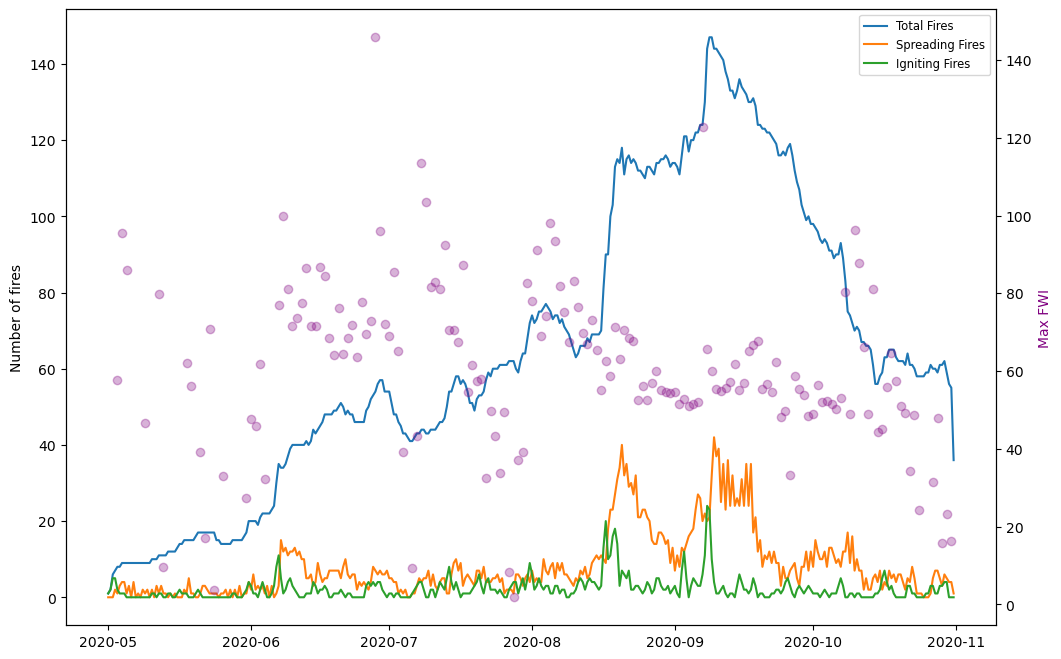

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
legend = ax.legend(loc='upper right', fontsize='small')
ax.set_ylabel("Number of fires", color = "Black")
ax2=ax.twinx()
#ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
#ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

ax2.set_ylabel("Max FWI",color="purple")

plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/Western_us_number_of_fire_timeseries.png", dpi=800)

Text(0, 0.5, 'Max FWI')

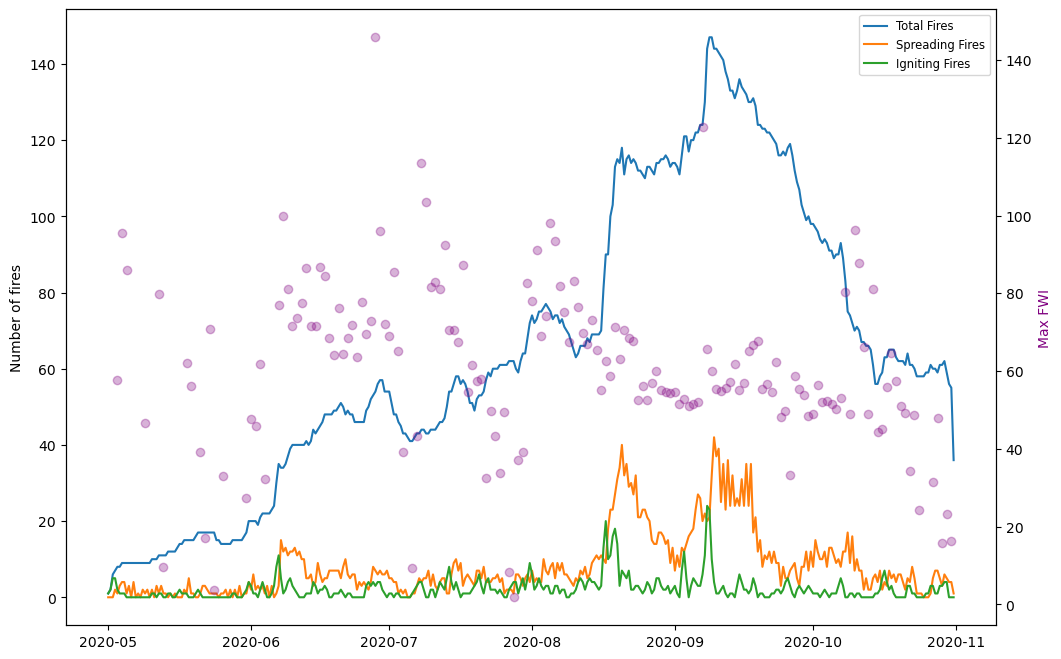

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
legend = ax.legend(loc='upper right', fontsize='small')
ax.set_ylabel("Number of fires", color = "Black")
ax2=ax.twinx()
#ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
#ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

ax2.set_ylabel("Max FWI",color="purple")

Text(0, 0.5, 'Fire Area')

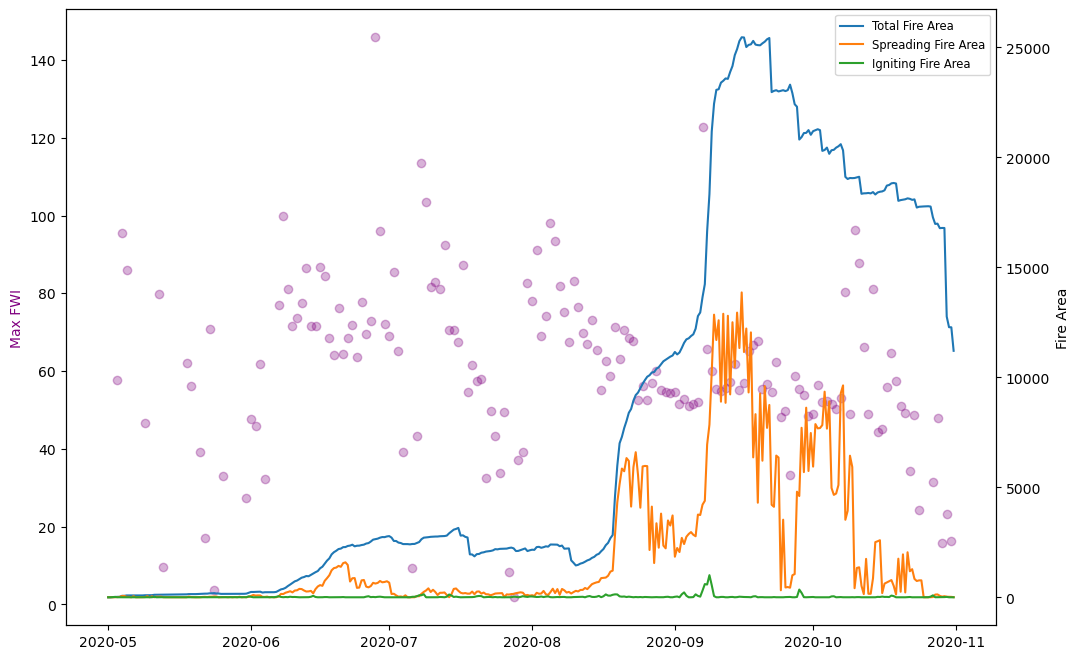

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")
ax.set_ylabel("Max FWI", color = "Purple")

ax2=ax.twinx()
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.area, label = "Total Fire Area")
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.area_spread, label = "Spreading Fire Area")
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_ig, label = "Igniting Fire Area")
legend = ax2.legend(loc='upper right', fontsize='small')
ax2.set_ylabel("Fire Area")

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
# legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
# ax.set_ylabel("Number of fires", color = "Black")
# ax2=ax.twinx()
# #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
# #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
# ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.mean_spread_fwi, alpha = 0.3, color = "purple")

# ax2.set_ylabel("Mean FWI",color="purple")

Text(0, 0.5, 'Cummulative Fire Area')

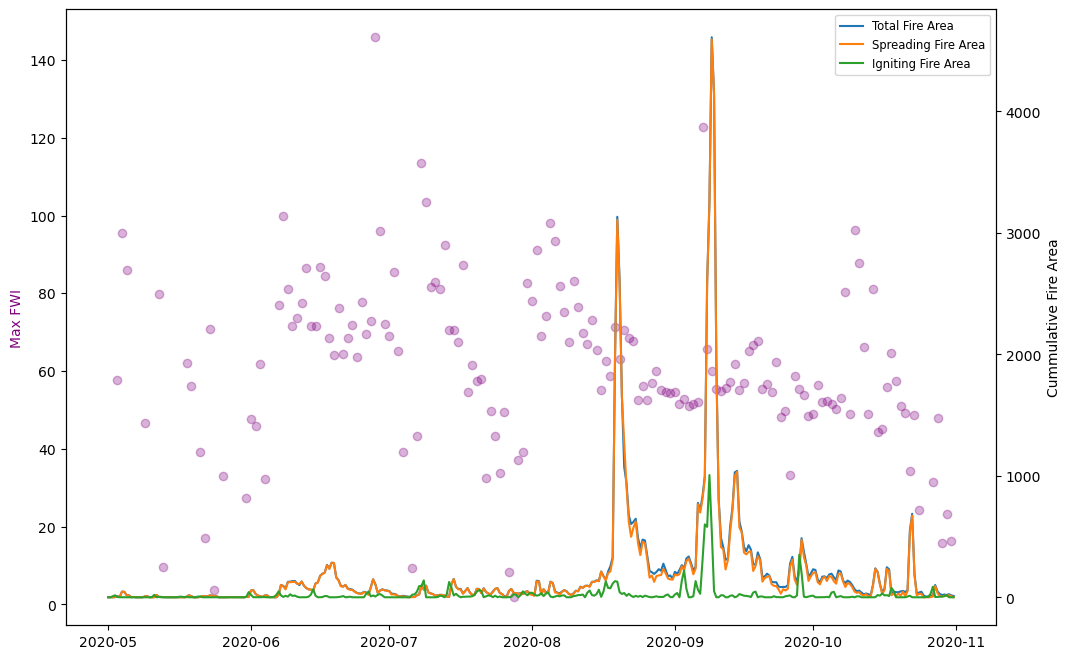

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")
ax.set_ylabel("Max FWI", color = "Purple")

ax2=ax.twinx()
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area, label = "Total Fire Area")
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_spread, label = "Spreading Fire Area")
ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_ig, label = "Igniting Fire Area")
legend = ax2.legend(loc='upper right', fontsize='small')
ax2.set_ylabel("Cummulative Fire Area")


Text(0, 0.5, 'FWI')

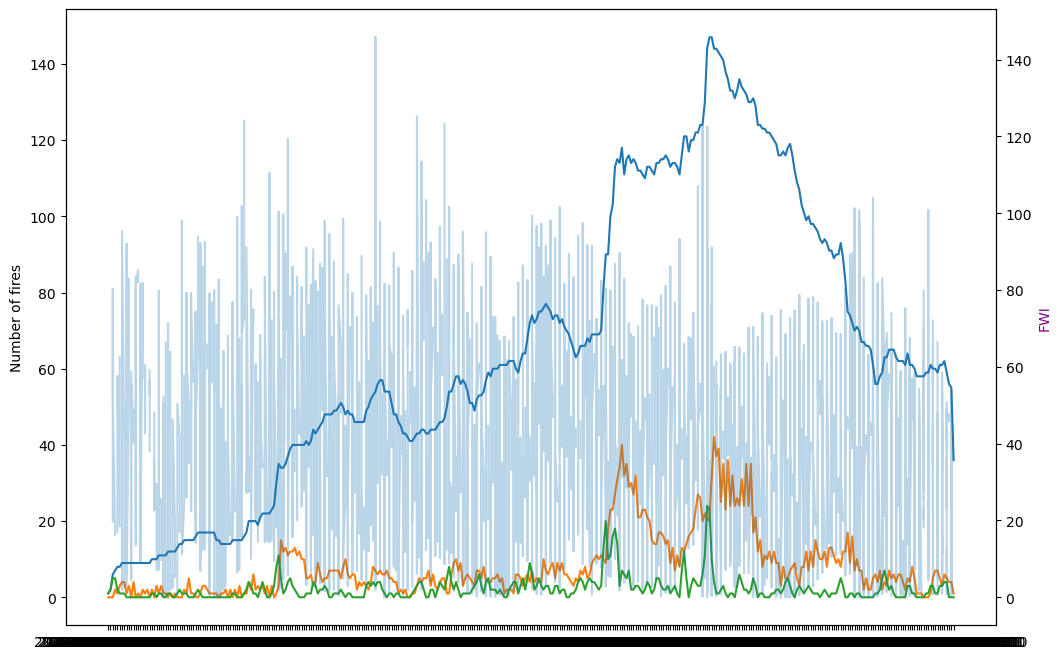

In [30]:
lag = 2

manyfr = manyfr.sort_values(by = ["t"])
manyfr["fwilag_24"] = manyfr["GPM.LATE.v5_FWI"].shift(lag)

manyfr

manyfr.spread_line[manyfr.spread_line == "True"] = 1
manyfr.spread_line[manyfr.spread_line == "False"] = 0

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(timeline.index, timeline.num_fires)
ax.plot(timeline.index, timeline.num_spread)
ax.plot(timeline.index, timeline.num_ig)
ax.set_ylabel("Number of fires", color = "black")
ax2=ax.twinx()
ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

ax2.set_ylabel("FWI",color="purple")

Text(0, 0.5, 'FWI')

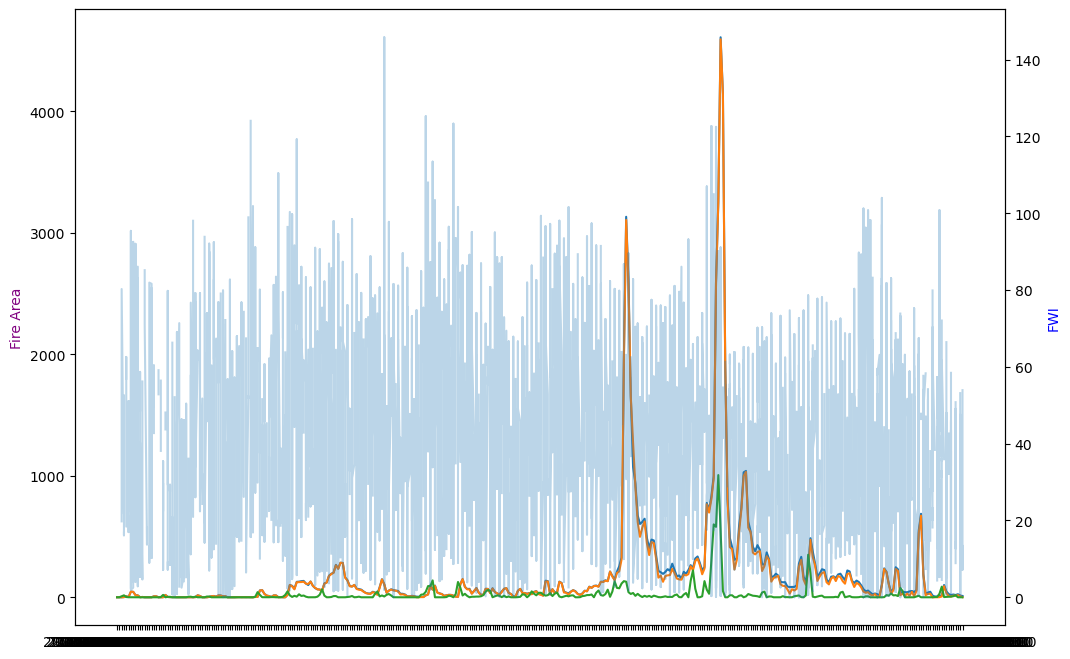

In [31]:
lag = 4

manyfr = manyfr.sort_values(by = ["t"])
manyfr["fwilag_24"] = manyfr["GPM.LATE.v5_FWI"].shift(lag)

manyfr

manyfr.spread_line[manyfr.spread_line == "True"] = 1
manyfr.spread_line[manyfr.spread_line == "False"] = 0

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(timeline.index, timeline.delta_area)
ax.plot(timeline.index, timeline.delta_area_spread)
ax.plot(timeline.index, timeline.delta_area_ig)
ax.set_ylabel("Fire Area", color = "purple")
ax2=ax.twinx()
ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

ax2.set_ylabel("FWI",color="blue")

Text(0, 0.5, 'Fire Area')

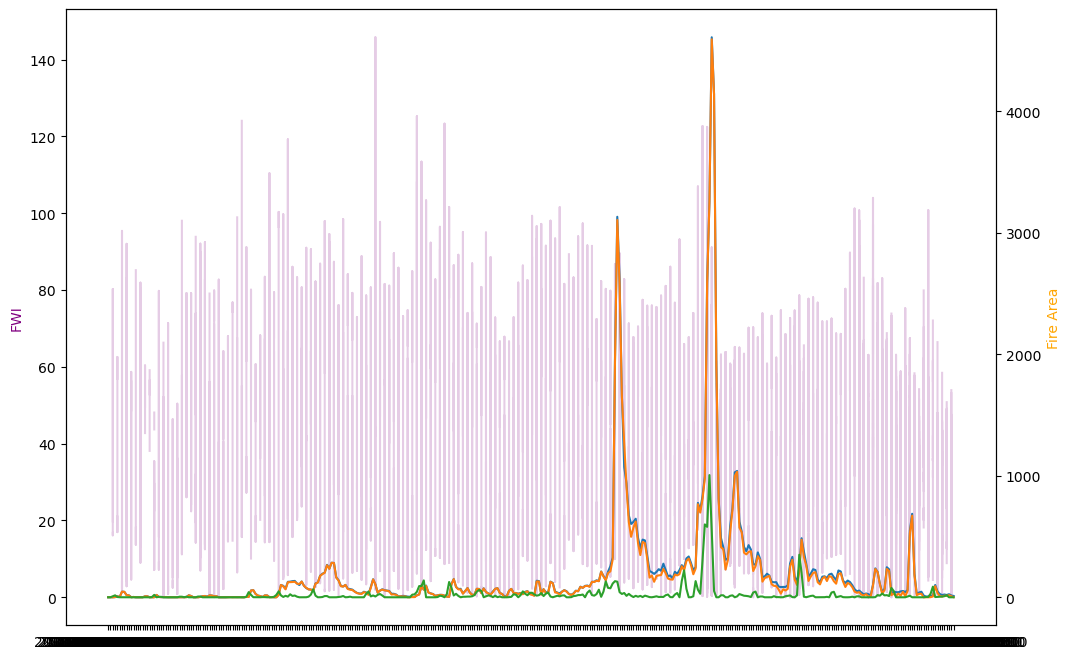

In [32]:
#manyfr.spread_line[manyfr.spread_line == "True"] = 1
#manyfr.spread_line[manyfr.spread_line == "False"] = 0

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(manyfr.t, manyfr["GPM.LATE.v5_FWI"], alpha = 0.2, color = "purple")
ax.set_ylabel("FWI",color="purple")

ax2=ax.twinx()
ax2.plot(timeline.index, timeline.delta_area)
ax2.plot(timeline.index, timeline.delta_area_spread)
ax2.plot(timeline.index, timeline.delta_area_ig)
ax2.set_ylabel("Fire Area", color = "Orange")

In [33]:
## Make fake "farea growth" taking into account ignitions

manyfr["fgrowth_merge"] = manyfr["farea_diff"]

manyfr.fgrowth_merge[(manyfr.spread_line.astype("str") == "2")] = manyfr[manyfr.spread_line.astype("str") == "2"].farea

manyfr[["GPM.LATE.v5_FWI", "farea", "farea_diff", "spread_line", "fgrowth_merge"]]

,GPM.LATE.v5_FWI,farea,farea_diff,spread_line,fgrowth_merge
3437,78.757650,0.141000,NaN,2,0.141000
3438,NaN,0.141000,NaN,2,0.141000
14090,NaN,0.282000,NaN,2,0.282000
12506,19.769463,0.370971,NaN,2,0.370971
3439,80.275650,0.282000,0.141000,0,0.141000
...,...,...,...,...,...
9243,NaN,454.783750,0.000000,0,0.000000
9248,NaN,6.330721,0.000000,0,0.000000
13901,NaN,4.067903,0.000000,0,0.000000
6703,NaN,5.080159,0.304111,0,0.304111


In [34]:
### Test a bunch of lags
import scipy.stats

timefr = manyfr.set_index("t")
timefr = timefr[timefr.farea_diff > 0]
timefr1 = timefr[["GPM.LATE.v5_FWI","farea_diff"]].dropna()

timefr2 = timefr[["GPM.LATE.v5_FWI", "fgrowth_merge"]].dropna()



lags = [-4, -3, -2, -1,0,1,2,3,4,5,6,7, 10]
lag_reg = []

for l in lags:
    lag_test =  timefr1["GPM.LATE.v5_FWI"].shift(l).dropna()
    lag_test2 =  timefr2["GPM.LATE.v5_FWI"].shift(l).dropna()
    #lag_test_spread = timefr[timefr.spread_line.astype("str") == "1"]["GPM.LATE.v5_FWI"].shift(l).dropna()

    
    #print(len(lag_test))
    diff_pr = scipy.stats.linregress(lag_test, timefr1.farea_diff.iloc[0:len(lag_test)])
    merge_pr = scipy.stats.linregress(lag_test2, timefr2.fgrowth_merge.iloc[0:len(lag_test2)])
    #spread_pr = scipy.stats.linregress(lag_test_spread, timefr[timefr.spread_line.astype("str") == "1"].farea_diff.iloc[0:len(lag_test_spread)].dropna())
    #spread_pr = scipy.stats.pearsonr(, manyfr[manyfr.spread_line == "True"].farea_diff.dropna())
    #ig_pr = spread_pr = scipy.stats.pearsonr(manyfr[manyfr.spread_line == "2"]["GPM.LATE.v5_FWI"].shift(l).dropna(), manyfr[manyfr.spread_line == "2"].farea.dropna())
    
    print("           Lag " , l ,  " had an R squared of: ", diff_pr.rvalue)
    print("FOR MERGE: Lag " , l ,  " had an R squared of: ", merge_pr.rvalue)
    lag_reg.append([l, str(diff_pr.rvalue)])
    #print("Lag " , l ,  " had an pval of: ", diff_pr.pvalue)
    #seq = range(0,len(lag_test))
    #plt.scatter(lag_test, timefr.farea_diff.iloc[0:len(lag_test)])
    #plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
    #plt.show()
    
    #print("FOR SPREAD_DAYS ONLY Lag " , l ,  " had an R squared of: ", spread_pr.rvalue)
    #print("Lag " , l ,  " had an pval of: ", diff_pr.pvalue)
    #seq = range(0,len(lag_test_spread))
    #plt.scatter(lag_test_spread, timefr[timefr.spread_line.astype("str") == "1"].farea_diff.iloc[0:len(lag_test)].dropna())
    #plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
    #plt.show
lag_reg = pd.DataFrame(lag_reg, columns = ["lag", "R"])

           Lag  -4  had an R squared of:  0.012799410325883984
FOR MERGE: Lag  -4  had an R squared of:  0.012799410325883984
           Lag  -3  had an R squared of:  0.022046204062752345
FOR MERGE: Lag  -3  had an R squared of:  0.022046204062752345
           Lag  -2  had an R squared of:  0.029006064686452938
FOR MERGE: Lag  -2  had an R squared of:  0.029006064686452938
           Lag  -1  had an R squared of:  0.001019468719525851
FOR MERGE: Lag  -1  had an R squared of:  0.001019468719525851
           Lag  0  had an R squared of:  0.0931992647183221
FOR MERGE: Lag  0  had an R squared of:  0.0931992647183221
           Lag  1  had an R squared of:  0.09314183920820696
FOR MERGE: Lag  1  had an R squared of:  0.09314183920820696
           Lag  2  had an R squared of:  0.09314639430391813
FOR MERGE: Lag  2  had an R squared of:  0.09314639430391813
           Lag  3  had an R squared of:  0.09309181565390195
FOR MERGE: Lag  3  had an R squared of:  0.09309181565390195
          

In [35]:
timeline["logged_area"] = np.log(timeline["area"])

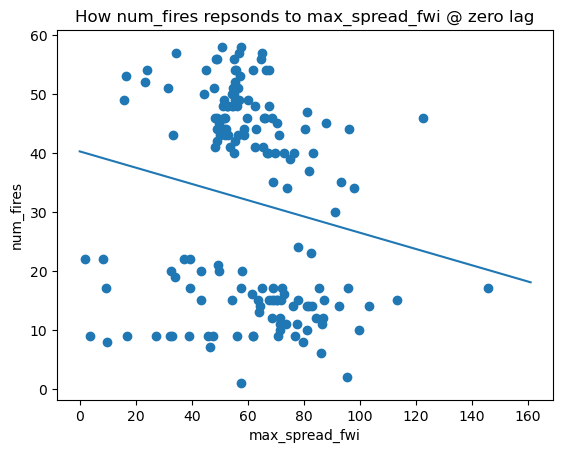

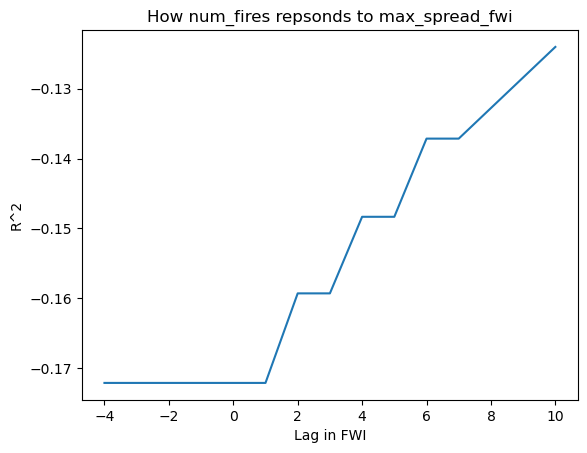

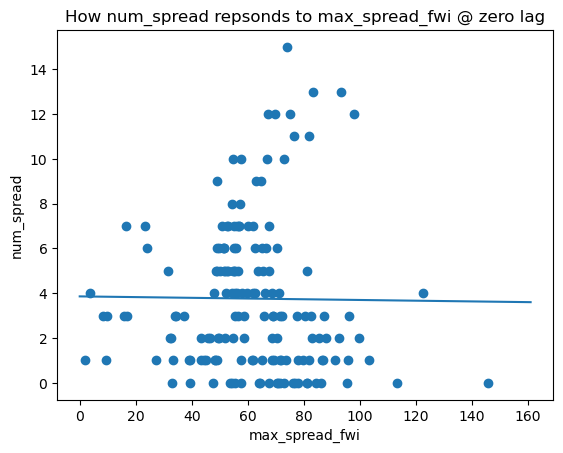

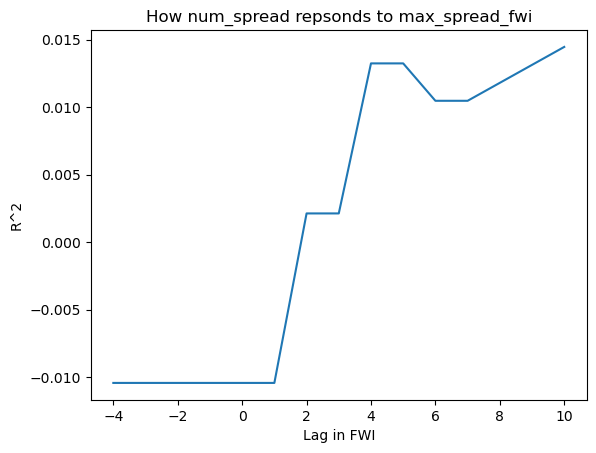

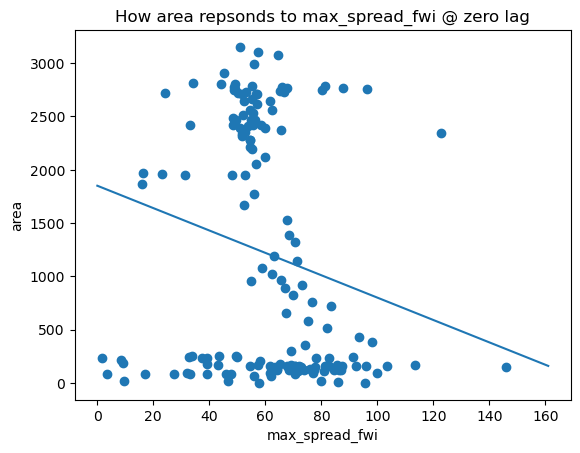

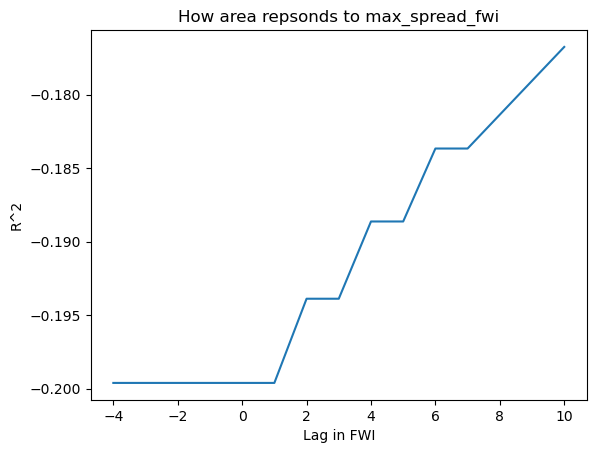

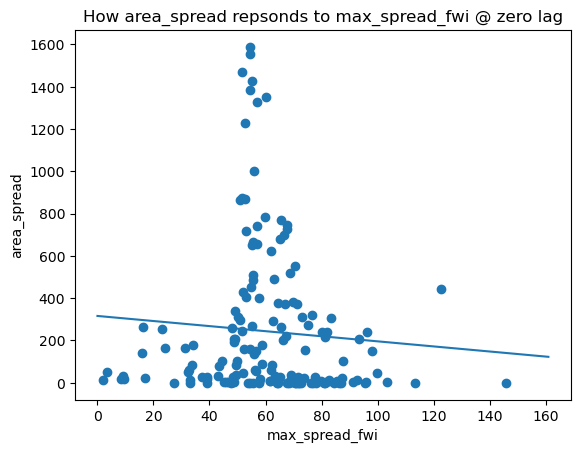

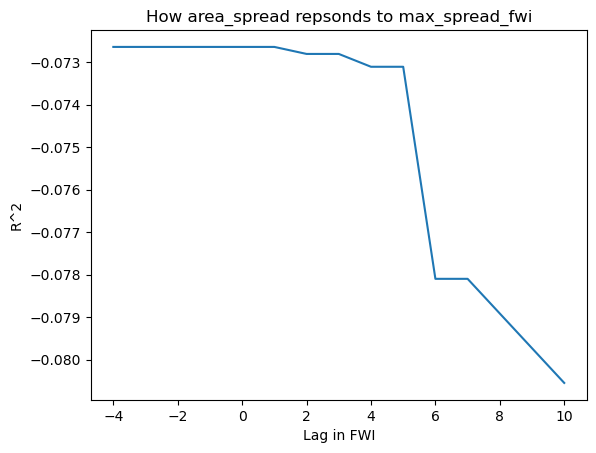

In [36]:
lags = [-4, -3, -2, -1,0,1,2,3,4,5,6,7, 10]
#response_var = ["num_fires", "num_spread", "num_ig","area", 'area_spread', 'logged_area','delta_area_ig', 'delta_area_spread']
#drive_var = ['mean_spread_fwi', 'mean_not_spread_fwi', 'max_spread_fwi']

response_var = ["num_fires", "num_spread", "area", 'area_spread', ]
drive_var = ['max_spread_fwi']


for r in response_var:
    for d in drive_var:
        
        lag_reg = []
        for l in lags:
            lag_test =  timeline[d].shift(l).dropna()
            #print(len(lag_test))
            mean_fwi_spread_pr = scipy.stats.linregress(lag_test, timeline[r].iloc[0:len(lag_test)])
            lag_reg.append([l, str(mean_fwi_spread_pr.rvalue)])
            if(l == 0): 
                seq = range(0, len(timeline[d].shift(l).dropna()))
                plt.scatter(timeline[d].shift(l).dropna(), timeline[r].iloc[0:len(lag_test)])
                plt.plot(seq, ((seq * mean_fwi_spread_pr.slope) + mean_fwi_spread_pr.intercept))
                plt.title("How " + r + " repsonds to " + d + " @ zero lag")
                plt.ylabel(r)
                plt.xlabel(d)
                plt.show()
        
        lag_reg = pd.DataFrame(lag_reg, columns = ["lag", "R"])

        plt.plot(lag_reg.lag, lag_reg.R.astype("float"))
#         plt.scatter(timeline[d].shift(l).dropna(), timeline[r].iloc[0:len(lag_test)])
        plt.title("How " + r + " repsonds to " + d)
        plt.ylabel("R^2")
        plt.xlabel("Lag in FWI")
        plt.show()

In [37]:
mean_fwi_spread_pr

LinregressResult(slope=-1.3934227978210767, intercept=330.10955786205164, rvalue=-0.08055047659033528, pvalue=0.31592847706525434, stderr=1.3849542392358662, intercept_stderr=90.7023095428238)

In [38]:
manyfr["intspread"] = manyfr.spread_line

manyfr.intspread[manyfr.intspread == "True"] = "1"
manyfr.intspread[manyfr.intspread == "False"] = "0"

color_dict = {'stay-day': '#2f7fb9','spread-day':'#fe953e', 'Ignition':'green'}


# plt.scatter(manyfr_d.t[manyfr_d.fireID == 7992].astype("datetime64[ns]"), manyfr_d.farea[manyfr_d.fireID == 7992], 
#             c = manyfr_d.intspread[manyfr_d.fireID == 7992].astype("int"), cmap = colors.ListedColormap(list(color_dict.values())))

# plt.ylabel("Fire Area")
# plt.xticks(rotation=90)
# plt.show()


plt.scatter( manyfr.fgrowth_merge[manyfr.fgrowth_merge > 0], manyfr["GPM.LATE.v5_FWI"][manyfr.fgrowth_merge > 0],
            c = manyfr[manyfr.fgrowth_merge > 0].intspread.astype("int"), cmap = colors.ListedColormap(list(color_dict.values())) )
plt.ylabel("FWI")
plt.xlabel("Fire area growth")

NameError: name 'colors' is not defined

In [ ]:
timefr[timefr.spread_line.astype("str") == ""]
#timefr

In [19]:
### Figure out what percentage of "first detections" are at night
ig_frame = []
igs = manyfr[manyfr.spread_line.astype(str) == "2"]

for i in igs.fireID.unique():
    ig = igs[igs.fireID == i]
    
    true_ig = min(ig.t)
    ig = ig[ig.t == true_ig]
    start_farea = max(ig.farea
    ig_frame.append([i, true_ig, start_farea])

ignitions = pd.DataFrame(data = ig_frame, columns = ["fireID", "ig_start", "farea"], dtype=object)
ignitions

SyntaxError: invalid syntax (1383248213.py, line 11)

In [ ]:
print("Daytime ignitions: ", len(ignitions[ignitions.ig_start.astype("datetime64[ns]").dt.hour > 0]))
print("Nighttime ignitions: ", len(ignitions[ignitions.ig_start.astype("datetime64[ns]").dt.hour < 12]))

ignitions["Day_start"] = ignitions.ig_start.astype("datetime64[ns]").dt.hour > 0


In [20]:
import matplotlib.colors as colors

color_dict = {'Nighttime Ignition':'blue', 'Daytime Ignition':'orange'}

In [18]:
plt.scatter(ignitions.ig_start.astype("datetime64[ns]"), ignitions.farea, 
            c = ignitions.Day_start.astype("bool"), cmap = colors.ListedColormap(list(color_dict.values()))) 
plt.legend()
plt.show()

print("Daytime ave fire size at first detection: ", np.mean(ignitions[ignitions.Day_start == True].farea))
print("Night-time ave fire size at first detection: ", np.mean(ignitions[ignitions.Day_start == False].farea))


print("Daytime range fire size at first detection: ", max(ignitions[ignitions.Day_start == True].farea), " , min: ",  min(ignitions[ignitions.Day_start == True].farea))
print("Night-time range fire size at first detection: ", max(ignitions[ignitions.Day_start == False].farea), " , min: ", min(ignitions[ignitions.Day_start == False].farea))
#ignitions.farea

NameError: name 'ignitions' is not defined

In [39]:
debug[debug.fireID.astype("str").isin(manyfr.fireID.astype("str").unique())]

,Unnamed: 0,fireID,func_failed,log


In [34]:
debug.fireID.astype("str")

0     6721
1     3329
2     9835
3     5267
4     5210
5     5216
6     6516
7     7939
8     1839
9     6467
10    5323
11    4890
12    5375
13    6472
14    3705
15    5251
16    6153
17    5376
18    6614
Name: fireID, dtype: object

In [35]:
manyfr.fireID.astype("str").unique()

array(['5', '36', '69', '73', '78', '70', '117', '196', '244', '577',
       '613', '674', '739', '749', '804', '881', '889', '1206', '1317',
       '1341', '1353', '1360', '1356', '1400', '1465', '1475', '1481',
       '1491', '1591', '1608', '1606', '1619', '1634', '1618', '1621',
       '1625', '1622', '1660', '1669', '1664', '1671', '1661', '1700',
       '1735', '1779', '1780', '1757', '1788', '1844', '1884', '2019',
       '2045', '2064', '2083', '2070', '2110', '2126', '2146', '2166',
       '2181', '2292', '2319', '2337', '2400', '2532', '2538', '2556',
       '2578', '2582', '2621', '2593', '2626', '2656', '2643', '2645',
       '2672', '2699', '2751', '2812', '2971', '3005', '3021', '3023',
       '3049', '3053', '3074', '3087', '3186', '3188', '3237', '3232',
       '3256', '3266', '3278', '3321', '3337', '3324', '3350', '3327',
       '3391', '3363', '3361', '3385', '3432', '3434', '3459', '3466',
       '3524', '3561', '3606', '3612', '3630', '3648', '3639', '3646',
      

In [40]:
gdf = fv.load_large_fire("36", year = "2020", path_region= "WesternUS")


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [41]:
# gdf = gdf.sort_values(by = "t")

# plt.plot(gdf.t, gdf.farea)

In [42]:
## Quick test of load_large_fires

# def load_large_fire(fireID, year = "2019", path_region = "WesternUS"):
#     '''
#     loads in largefire file based on fireID and layer, then preps it for "explore" by adding centriod data. Currently limited to one year. 
    
#     INPUTS:
        
#         fireID (str): fireID offire of interest. Can be found in gdf files read in by prep_gdf and load_file. Can be selected interactivly form a gdf if use gdf.explore()
#         year (str): Year that fires took place. Default to 2019. Availible options differ by path_region. 
#         path_region (str): This constructs the path that the fires are stored in. WesternUS and CONUS availible. 
#     '''
#     lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*') 
#     lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
#     largefire_dict = dict.fromkeys(lf_ids)
    
#     for lf_id in lf_ids:
#          most_recent_file = [file for file in lf_files if lf_id in file][-1]
#          largefire_dict[lf_id] = most_recent_file
    
#     gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
#                    ignore_index=True)
#     gdf = gdf.to_crs('EPSG:4326')
#     gdf['lon'] = gdf.centroid.x
#     gdf['lat'] = gdf.centroid.y
#     return gdf

In [43]:
# import glob

# fireID = "36"
# #fireID = "5037"
# year = "2020" 
# path_region= "WesternUS"


# lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*') 
# lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
# largefire_dict = dict.fromkeys(lf_ids)

# for lf_id in lf_ids:
#     print(lf_ids)
#     most_recent_file = [file for file in lf_files if lf_id in file][-1]
#     print(most_recent_file)
#     largefire_dict[lf_id] = most_recent_file
#     print(largefire_dict)

# gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
#               ignore_index=True)
# #gdf = gdf.to_crs('EPSG:4326')
# #gdf['lon'] = gdf.centroid.x
# #gdf['lat'] = gdf.centroid.y

In [44]:
# gdf_better = load_large_fire("36", year = "2020", path_region= "WesternUS")

In [45]:
# gdf_better = gdf_better.sort_values(by = "t")

# plt.scatter(gdf_better.t, gdf_better.farea)

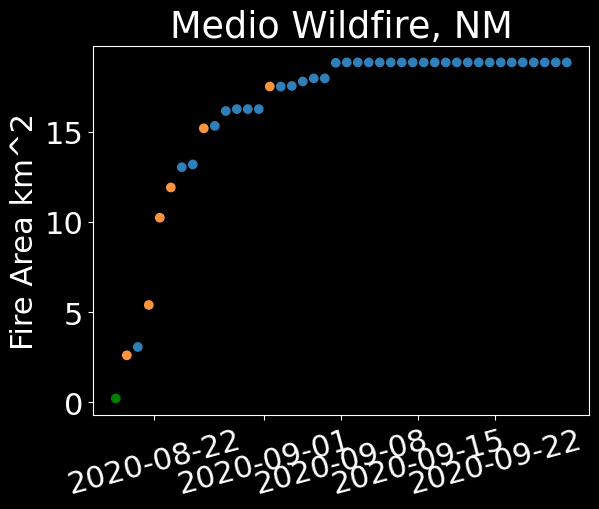

In [21]:

manyfr_d["intspread"] = manyfr_d.spread_line

manyfr_d.intspread[manyfr_d.intspread == "True"] = "1"
manyfr_d.intspread[manyfr_d.intspread == "False"] = "0"

color_dict = {'stay-day': '#2f7fb9','spread-day':'#fe953e', 'Ignition':'green'}


plt.scatter(manyfr_d.t[manyfr_d.fireID == 5214].astype("datetime64[ns]"), manyfr_d.farea[manyfr_d.fireID == 5214], 
            c = manyfr_d.intspread[manyfr_d.fireID == 5214].astype("int"), cmap = colors.ListedColormap(list(color_dict.values())))

plt.ylabel("Fire Area km^2")
plt.xticks(rotation=15)
plt.title("Medio Wildfire, NM")

#plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/medio_wildfire.png", dpi=800)
plt.show()

In [ ]:




manyfr.intspread[manyfr.fireID == 36].astype("int").unique()

In [ ]:
snap = fv.prep_gdf(date = '20201031PM',layer='perimeter',handle_multi=False,only_lf=True,area_lim=4.7, year = "2020", path_region = "WesternUS")

In [ ]:
#snap[snap.index == 5214].explore()
snap.explore()

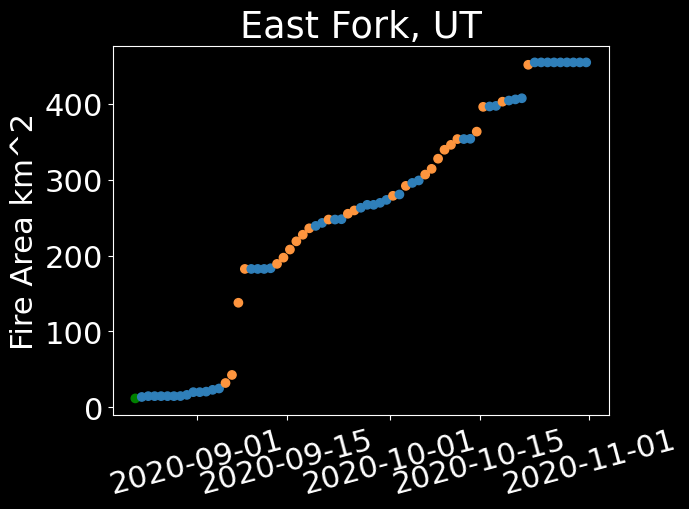

In [22]:

manyfr_d["intspread"] = manyfr_d.spread_line

manyfr_d.intspread[manyfr_d.intspread == "True"] = "1"
manyfr_d.intspread[manyfr_d.intspread == "False"] = "0"

color_dict = {'stay-day': '#2f7fb9','spread-day':'#fe953e', 'Ignition':'green'}


plt.scatter(manyfr_d.t[manyfr_d.fireID == 5588].astype("datetime64[ns]"), manyfr_d.farea[manyfr_d.fireID == 5588], 
            c = manyfr_d.intspread[manyfr_d.fireID == 5588].astype("int"), cmap = colors.ListedColormap(list(color_dict.values())))

plt.ylabel("Fire Area km^2")
plt.xticks(rotation=15)
plt.title("East Fork, UT")

plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/East_fork_area.png", dpi=800)

In [ ]:
snap[snap.index == 5588].explore()
